In [1]:
import os
import sys

sys.path.insert(0, '/home/lclaeys/eigenfunction-solver')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm

In [3]:
from src.energy.quadratic import QuadraticEnergy
from src.eigensolver.neural.network.feedforward import FeedForwardNetwork, ConstantFFN
from src.eigensolver.neural.loss.orth_loss import BasicOrthogonalityLoss, CovOrthogonalityLoss
from src.eigensolver.neural.loss.variational_loss import VariationalLoss
from torch.utils.data import Dataset, DataLoader


In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
dim = 2
m = 3
N = 50000
energy = QuadraticEnergy(np.eye(dim))
x = torch.tensor(energy.exact_sample((N,)), requires_grad = False)

In [6]:
model = ConstantFFN([dim,200,200,2000,200,m])

In [7]:
var_loss = VariationalLoss()
orth_loss = BasicOrthogonalityLoss()

In [8]:
lr = 1e-2
#optimizer = optim.Adam(model.parameters(), lr = lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # SGD with momentum

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


In [9]:
grad_outputs = torch.eye(m)[:,None,:].expand([m,N,m])

In [10]:
dataloader = DataLoader(
    x,
    batch_size=5000,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [11]:
beta = 0.5
orth_cost = []
var_cost = []
for epoch in range(10000):  # Train for 100 epochs
    for batch_idx, data in enumerate(dataloader):
        data = data.requires_grad_()
        optimizer.zero_grad()  # Clear gradients
        fx = model(data)  # Forward pass

        grad_outputs = torch.eye(m)[:,None,:].expand([m,data.shape[0],m])

        grad_fx = torch.autograd.grad(outputs = fx, inputs = data, grad_outputs = grad_outputs, is_grads_batched=True, create_graph=True)[0].transpose(0,1)
        loss_1 = var_loss(grad_fx)  # Variational loss
        loss_2 = orth_loss(fx)
        
        orth_cost.append(loss_2)
        var_cost.append(loss_1)

        loss = beta*loss_1 + loss_2
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        scheduler.step()
    
        print(f"Epoch {epoch + 1}, batch {batch_idx}/{len(dataloader)}, lr: {scheduler.get_last_lr()[0]:.2e}, Loss: {loss.item():.3e}, Loss_1: {loss_1.item():.3e}, Loss_2: {loss_2.item():.3e}", end = '\r')



KeyboardInterrupt: 

In [23]:
grad_fx

tensor([[[ 0.0000,  0.0000],
         [-0.0339, -0.0256],
         [-0.0476, -0.0334]],

        [[ 0.0000,  0.0000],
         [-0.0162, -0.0449],
         [-0.0469, -0.0212]],

        [[ 0.0000,  0.0000],
         [-0.0200, -0.0437],
         [-0.0492, -0.0272]],

        ...,

        [[ 0.0000,  0.0000],
         [ 0.0126, -0.0050],
         [-0.0093, -0.0101]],

        [[ 0.0000,  0.0000],
         [-0.0025, -0.0072],
         [-0.0365,  0.0033]],

        [[ 0.0000,  0.0000],
         [ 0.0123, -0.0022],
         [-0.0229, -0.0022]]], grad_fn=<TransposeBackward0>)

In [36]:
for param in model.parameters():
    torch.nn.init.uniform_(param, a=-1.0, b=1.0)

In [23]:
data = data.requires_grad_()
# fx = 1/6*(data)**3 @ torch.tensor([[1,0,0],[0,1,0]],dtype=torch.float64)
# fx = model.forward(data)

grad_outputs = torch.eye(m)[:,None,:].expand([m,data.shape[0],m])
grad_fx = torch.autograd.grad(outputs = fx, inputs = data, grad_outputs = grad_outputs, is_grads_batched=True, create_graph=True)[0].transpose(0,1)

laplacian = torch.zeros(data.shape[0], m)  # Shape: [batch_size, m]
for i in range(data.shape[1]):  # Loop over input dimensions
    second_derivatives = torch.autograd.grad(
        outputs=grad_fx[:, :, i],  # First derivative w.r.t. data[:, i]
        inputs=data,
        grad_outputs=grad_outputs,  # Scalar tensor for gradients
        is_grads_batched=True,
        create_graph=True
    )[0].transpose(0,1)[:, :, i]  # Extract diagonal second derivative for input i
    laplacian += second_derivatives
print(data)
print(laplacian)

tensor([[ 1.5148,  0.3357],
        [-1.2070,  0.2114],
        [ 0.7853, -0.7413],
        ...,
        [-1.0368, -1.3482],
        [-0.6729,  1.2756],
        [-0.3227,  0.2393]], requires_grad=True)
tensor([[-0.3194, -0.5795,  0.0000],
        [ 0.5039, -0.3986,  0.0000],
        [-0.7475,  0.7599,  0.0000],
        ...,
        [ 0.6164,  0.4137,  0.0000],
        [ 0.7695, -0.4592,  0.0000],
        [ 0.5631, -0.4437,  0.0000]], grad_fn=<AddBackward0>)


In [39]:
from torch.func import hessian, vmap, functional_call

params = dict(model.named_parameters()) #params (need to be an input for torch.func to work)

#functionalize version (params are now an input to the model)
def fcall(params, x):
  return functional_call(model, params, x)

def compute_laplacian(params, x):
  _hessian_wrt_x = hessian(fcall, argnums=1)(params, x) #forward-over-reverse hessian calc.
  _laplacian_wrt_x = _hessian_wrt_x.diagonal(0,-2,-1) #use relative dims for vmap (function doesn't see the batch dim of the input)
  return _laplacian_wrt_x

#We define a laplacian func for a single function, then vectorize over the batch.
laplacian = vmap(compute_laplacian, in_dims=(None,0))(params, x) 

RuntimeError: vmap: inplace arithmetic(self, *extra_args) is not possible because there exists a Tensor `other` in extra_args that has more elements than `self`. This happened due to `other` being vmapped over but `self` not being vmapped over in a vmap. Please try to use out-of-place operators instead of inplace arithmetic. If said operator is being called inside the PyTorch framework, please file a bug report instead.

In [195]:
second_derivatives = torch.autograd.grad(
        outputs=grad_fx[:, :, 0],  # First derivative w.r.t. data[:, i]
        inputs=data,
        grad_outputs=grad_outputs,  # Scalar tensor for gradients
        is_grads_batched=True,
        create_graph=True,
        #allow_unused=True
    )

In [221]:
model(x[0][None,:])[0,0]

tensor(1., grad_fn=<SelectBackward0>)

In [232]:
model_fn = lambda x: model(x[None,:])[0,2]

In [233]:
model_fn(x[1,:])

tensor(-3739.4986, grad_fn=<SelectBackward0>)

In [234]:
torch.autograd.functional.hessian(model_fn, x[0])

tensor([[0., 0.],
        [0., 0.]])

In [127]:
torch.autograd.grad(outputs = grad_fx, inputs = data, grad_outputs = )

RuntimeError: grad can be implicitly created only for scalar outputs

In [126]:
grad_fx = torch.autograd.grad(outputs = fx, inputs = data, grad_outputs = grad_outputs, is_grads_batched=True, create_graph=True)[0].transpose(0,1)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

(0.0, 10.0)

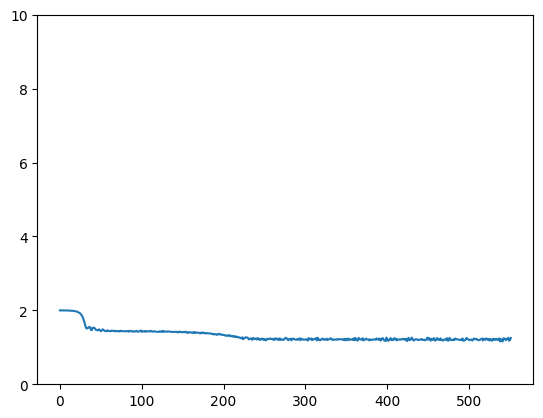

In [116]:
plt.plot((torch.tensor(var_cost)*beta+torch.tensor(orth_cost)).detach())

plt.ylim(0,10)

(0.0, 20.0)

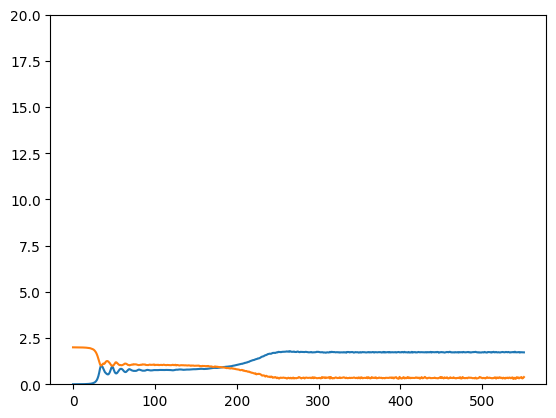

In [117]:
plt.plot(torch.tensor(var_cost).detach())
plt.plot(torch.tensor(orth_cost).detach())

plt.ylim(0,20)

In [16]:
x_eval = torch.linspace(-2,2,10000)[:,None]
fx_eval = model(x_eval).detach()
eigfuncs = torch.tensor(energy.exact_eigfunctions(x_eval.numpy(), m))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x1 and 2x200)

In [8]:
# deconstruct

x_pca = torch.tensor(energy.exact_sample((N,)))
fx_pca = model(x_pca).detach()[:,1:]

cov = torch.cov(fx_pca.T)

In [9]:
D, U = torch.linalg.eigh(cov)
eigvals = 2/beta*(1-D)
rotation = torch.diag(1/D**(1/2))@U.T

NameError: name 'beta' is not defined

In [17]:
fx_eval[:,1:] = fx_eval[:,1:]@rotation

NameError: name 'fx_eval' is not defined

In [18]:
_, indices = torch.sort(eigvals)
fx_eval[:,1:] = fx_eval[:,1+indices]

NameError: name 'eigvals' is not defined

In [19]:
colors = ['black', 'red', 'green', 'blue', 'orange']
# Create the plot
plt.figure(figsize=(10, 6))

for i in range(4):
    # Plot array1 with full lines
    plt.plot(x_eval, fx_eval[:, i], color=colors[i], label=f'Fitted m = {i}', linestyle='--')
    
    # Plot array2 with dashed lines
    plt.plot(x_eval, eigfuncs[:, i], color=colors[i], label=f'True m = {i}')

# Add legend and labels
plt.legend()
#plt.ylim(-2,2)

NameError: name 'fx_eval' is not defined

<Figure size 1000x600 with 0 Axes>

In [30]:
rng = np.random.default_rng(42)
samples = x

In [32]:
samples.shape
num_samples = 1000

In [34]:
x = rng.choice(samples.detach(), size = num_samples, axis=0)

In [65]:
from torch.utils.data import Dataset, DataLoader

# Dataset and DataLoader
dataloader = DataLoader(
    x,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [66]:
for data in dataloader:
    print(data.shape)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ~~~~~~~~~~~~~~~^^^^^^
  File "/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lclaeys/miniconda3/envs/efs-env/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
RuntimeError: stack(): functions with out=... arguments don't support automatic differentiation, but one of the arguments requires grad.
